**решающее дерево**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X_train,y_train = make_moons(n_samples=500,noise=.09)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

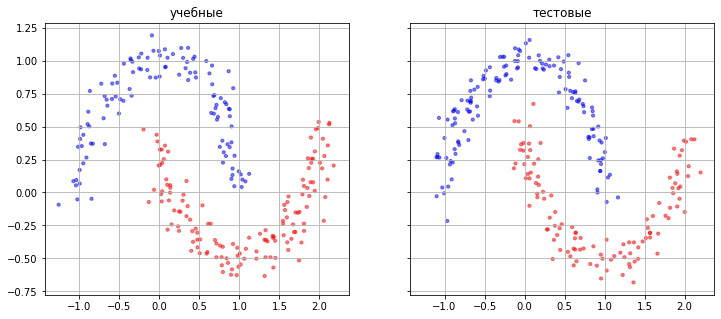

In [3]:
def plot(X,y,ax,t): 
    ax.scatter(x=X[:,0],y=X[:,1],c=np.array(['b','r'])[y],s=10,alpha=.5)
    ax.grid()
    ax.set_title(t)

fig,(ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot(X_train,y_train,ax0,'учебные')
plot(X_test,y_test,ax1,'тестовые')
plt.show()

**энтропийный критерий - информационный выигрыш (Information gain)**

Пусть ω0, ω1 — два исхода с вероятностями $q$ и $1−q$    

Количество информации:  
    $$I_0 = − log_2(q)$$  
    $$I_1 = − log_2(1 − q)$$ 

Энтропия - математическое ожидание количества информации:  

$$h(q) = −q \cdot log_2(q) − (1−q)\cdot log_2(1 − q)$$

Энтропия выборки $X$, если исходы — это классы $y=c$, $y\neq c$:
$$H(y) = h\left( \frac{P}{S} \right)$$
P - количество позитивных объектов

S - общее количество объектов

Энтропия выборки $X$ после получения информации $R$: 

$$H(y|R)=\frac{p+n}{s} \cdot h\left(\frac{p}{p+n}\right) + \frac{s-p-n}{s} \cdot h\left( \frac{P-p}{s-p-n} \right)$$


Информационный выигрыш (Information gain):
$$iGain(y,R) = H(y) − H(y|R)$$



- S - общее количество объектов
- P - количество положительных примеров
- p - количество положительных примеров, выделеных предикатом
- n - количество отрицательных примеров, выделеных предикатом




In [4]:
# энтропийный критерий - информационный выигрыш (Information gain, IGain):
def h(q):
    with np.errstate(divide='ignore',invalid='ignore'):
        l1 = np.where(q>0, q*np.log2(q), 0. )    
        l2 = np.where(q<1., (1.-q)*np.log2(1.-q), 0. )    
    return -l1 - l2

# разница в информативности, до и после примения предиката
def igain(s,p_y,p,n):
    # s - количество примеров
    # p_y - количество положительных
    # p - количество положительных примеров, выделенных предикатом   
    # n - количество отрицательных примеров, выделенных предикатом
    
    return h(p_y/s) - ( (p+n)/s * h(p/(p+n)) + (s-p-n)/s * h( (p_y-p)/(s-p-n)) )

# считаем информативность предиката x>b для разметки y
def info(x,y,b):
    s = len(y) # общее количество примеров
    p_all = y.sum() # количество положительных примеров
    f = x>b #  отмечаем примеры выделенные предикатом 
    p = (y[f]==1).sum() # количество положительных примеров, выделенных предикатом   
    n = (y[f]==0).sum() # количество отрицательных примеров, выделенных предикатом
    return igain(s,p_all,p,n) # разница в информативности

Алгоритм обучения выглядит следующим образом.

1. если X содержит точки только одного класса то создать лист с меткой класса и переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. создать узел дерева и сохранить там найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

In [5]:
def search_split(X,y,nb=30):
    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] for i in range(X.shape[1]) ])

    # изменение информативности для разных признаков и значений порогов 
    split_inf = np.array([ 
        [ info(X[:,i],y,b[i,j]) for i in range(X.shape[1])  ] 
        for j in range(b.shape[1]) 
    ])

    # параметры с максимальным значением информативности
    j,i = np.unravel_index(split_inf.argmax(),split_inf.shape)

    return i,b[i,j],split_inf[j,i] # номер признака, порог, значение информативности

In [11]:
def id3(X,y):
    if (y==1).all() or (y==0).all(): # если разбиение содержит точки одного класса
        return {'type':'leaf','value':y[0]} # то создаём лист с меткой класса
    i,b,si = search_split(X,y) # ищем оптимальное разделение по признаку
    f = X[:,i]>b 
    return {  # создаём узел дерева
        'type':'node',
        'threshold':b, # порог
        'feature':i, # номер признака
        'info':si, # информативность разбиения
        'less': id3(X[~f,:],y[~f]), # повторяем рекурсивно для двух частей
        'more': id3(X[f,:],y[f])
    }

In [12]:
tree = id3(X_train,y_train)

In [13]:
tree

{'type': 'node',
 'threshold': 0.5625955159617385,
 'feature': 1,
 'info': 0.43631571181643847,
 'less': {'type': 'node',
  'threshold': -0.6651691665919595,
  'feature': 0,
  'info': 0.2761657426206813,
  'less': {'type': 'leaf', 'value': 0},
  'more': {'type': 'node',
   'threshold': 0.021076680407607906,
   'feature': 1,
   'info': 0.2067557299307144,
   'less': {'type': 'leaf', 'value': 1},
   'more': {'type': 'node',
    'threshold': 1.1950132958653055,
    'feature': 0,
    'info': 0.3302963814355808,
    'less': {'type': 'node',
     'threshold': 0.3487115899946529,
     'feature': 0,
     'info': 0.9867867202680318,
     'less': {'type': 'leaf', 'value': 1},
     'more': {'type': 'leaf', 'value': 0}},
    'more': {'type': 'leaf', 'value': 1}}}},
 'more': {'type': 'leaf', 'value': 0}}

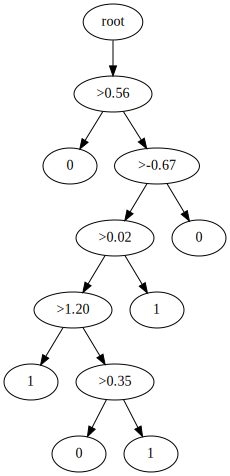

In [54]:
from collections import Counter
import graphviz

dot = graphviz.Digraph()
dot.node('root',)

def plot(tree,dot,root='root',counter=Counter('node')):
    n = counter['node']
    counter['node']+=1
    label = f'node{n}' 
    if tree['type']=='node':
        dot.node(label,'>%.2f'%(tree['threshold']))
        plot(tree=tree['more'],dot=dot,root=label,counter=counter)
        plot(tree=tree['less'],dot=dot,root=label,counter=counter)
    else:
        dot.node(label,'%i'%tree['value'])
    dot.edge(root,label)
    return dot 

plot(tree,dot)

In [53]:
# dot = graphviz.Digraph(comment='The Round Table')
# dot.node('A', 'King Arthur')
# dot.node('B', 'Sir Bedevere the Wise')
# dot.node('L', 'Sir Lancelot the Brave')
# dot.edges(['AB', 'AL'])
# dot.edge('B', 'L', constraint='false')
# dot


# dot = graphviz.Digraph()
# # dot.node('C',)
# dot.edges(['AB', 'AL'])
# # dot.edge('A', 'C')
# dot

In [ ]:
# def split(X,tree):

#     if tree['type']=='leaf': 
#         return tree['value']
    
#     f = X>tree['threshold']

In [ ]:
# def split_subset(X,p,Xpos,Xneg):
#     if(type(p).__name__ == 'Leaf'): 
#         if p.mark > 0: 
#             Xpos.append(X)
#         else:
#             Xneg.append(X)
#         return [Xpos,Xneg]

#     f = X[:,p.feature]>p.bound
    
#     XposL,XnegL = split_subset( X[f,:],  p.left,  Xpos, Xneg )
#     XposR,XnegR = split_subset( X[~f,:], p.right, Xpos, Xneg )

#     return [XposL+XposR,XnegL+XnegR]


# def split_data(X,p):
#     Xpos,Xneg = split_subset(X,p,[],[])
#     Xpos = np.vstack(Xpos)
#     Xneg = np.vstack(Xneg)
#     return Xpos,Xneg


In [ ]:
fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,12),)
plot(X_train,y_train,ax0,'учебные')
plot(X_test,y_test,ax1,'тестовые')

Xpos,Xneg = split_data(X_train,dtree)
X = np.vstack([Xpos,Xneg])
y = [1]*len(Xpos)+[0]*len(Xneg)
plot(X,y,ax2,'результат на учебных')

Xpos,Xneg = split_data(X_test,dtree)
X = np.vstack([Xpos,Xneg])
y = [1]*len(Xpos)+[0]*len(Xneg)
plot(X,y,ax3,'результат на тестовых')

plt.show()